# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# script to save MPA mask on regular mesh as netcdf file
#
# note that some paths are hard-coded throughout the script

In [ ]:
#import geopandas as gpd
#import shapefile
#import fiona
import numpy as np
#import geopandas as gpd
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import xarray as xr

In [6]:
#---
# existing MPAs
#---

file1 = '/global/cscratch1/sd/cnissen/shape_files/mpa/existing/existing_mpa.shp'
mpas1 = gp.read_file("/global/cscratch1/sd/cnissen/shape_files/mpa/existing/")

#---
# proposed MPAs
#---

file2 = '/global/cscratch1/sd/cnissen/shape_files/mpa/proposed/proposed_mpa.shp'
mpas2 = gp.read_file("/global/cscratch1/sd/cnissen/shape_files/mpa/proposed/")

#---
# CCAMLR
#---
#
#file3 = '/global/cscratch1/sd/cnissen/shape_files/mpa/ccamlr/ccamlr.shp'
#mpas3 = gp.read_file("/global/cscratch1/sd/cnissen/shape_files/mpa/ccamlr/")



# select whichever lon/lat you want from your dataset

# regular mesh or FESOM coordinates

# NOTE: FESOM mesh does not work yet (memory issues; I think the regionmask function tries to make a 2D array...)
#meshfile = '/global/cscratch1/sd/cnissen/Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'
#ff = xr. open_dataset(meshfile)
#lon2  = ff['lon'].values
#lat2  = ff['lat'].values
#lon=lon2
#lat=lat2
#print(lon2.shape,lat2.shape)
#indSO = np.where(lat<-70)[0]
#print(indSO.shape)
#print('get mask_existing...')
#mask_existing = regionmask.mask_geopandas(mpas1, lon[indSO], lat[indSO], wrap_lon=False)
#print('get mask_proposed...')
#mask_proposed = regionmask.mask_geopandas(mpas2, lon[indSO], lat[indSO], wrap_lon=False)


res = 0.125 #1, 0.5, 0.025, 0.125
# NOTE: 0.125 is toothfish grid; 0.25 in x direction, 0.125 in y direction

if res==0.125:
    lon = np.arange(-180+0.25/2.,(180-0.25/2.)+0.25,0.25)
    lat = np.arange(-90+res/2.,-45-res/2.+res,res) 
else:
    lon = np.arange(-180+res/2,(180-res/2)+res,res)
    lat = np.arange(-89.5,-59.5+res,res) 
    
lat2,lon2 = np.meshgrid(lat,lon)

print('get mask_existing...')
mask_existing = regionmask.mask_geopandas(mpas1, lon, lat, wrap_lon=False)
print('get mask_proposed...')
mask_proposed = regionmask.mask_geopandas(mpas2, lon, lat, wrap_lon=False)
#print('get ccamlr...')
#mask_ccamlr = regionmask.mask_geopandas(mpas3, lon, lat, wrap_lon=False)

print(mask_existing.shape)
print(mask_proposed.shape)
print(lat2.shape)
print(lon2.shape)

# only do this for Ross Sea (mask out everything else):
#ind = np.where((lon<100) & (lon>-140))[0]
#mask[:,ind] = np.nan

print('done')

get mask_existing...
get mask_proposed...
(360, 1440)
(360, 1440)
(1440, 360)
(1440, 360)
done


In [ ]:
test_plot = False
if test_plot: 
    #plt.pcolor(lon2,lat2,mask_ccamlr.transpose())
    #plt.colorbar()
    #plt.show()
    
    plt.pcolor(lon2,lat2,mask_proposed.transpose())
    plt.colorbar()
    plt.show()

    plt.pcolor(lon2,lat2,mask_existing.transpose())
    plt.colorbar()
    plt.show()
    

In [15]:
#----
# get separate masks for each MPA
#----

mask_Ross   = np.nan*np.ones_like(mask_existing)
mask_Orkney = np.nan*np.ones_like(mask_existing)
print(mask_existing.shape)
print(mask_Ross.shape)

mask_WAP      = np.nan*np.ones_like(mask_proposed)
mask_Weddell  = np.nan*np.ones_like(mask_proposed)
mask_EastAA_1 = np.nan*np.ones_like(mask_proposed)
mask_EastAA_2 = np.nan*np.ones_like(mask_proposed)
mask_EastAA_3 = np.nan*np.ones_like(mask_proposed)

print(mask_WAP.shape)

#----
# proposed MPAs
#----
ind = np.where(mask_proposed>4)#[0]
mask_WAP[ind] = 1 # WAP
del ind

update_WAP = True
if update_WAP:
    path = '/global/cscratch1/sd/cnissen/shape_files/masks_MPAs/'

    if res==0.125:
        ff = xr. open_dataset(path+'Mask_cavities_regular_mesh_'+str(res)+'deg_toothfish_project.nc')
    else:
        ff = xr. open_dataset(path+'Mask_cavities_regular_mesh_'+str(res)+'deg.nc')
    topo  = ff['topo'].values
    topo = np.ma.masked_where(topo>9999,topo)
    ff.close()
    print('Min/Max topo:',np.min(topo),np.max(topo))

    # Antarctic Peninsula: try to adapt to newer version of domain 1 MPA
    ind2 = np.where((lon2.transpose()>-81.3) & (lon2.transpose()<-65) & (lat2.transpose()>-73) & (topo<2800)) #[0]
    mask_WAP[ind2] = 1
    #
    ind2 = np.where((lon2.transpose()>-81.3) & (lon2.transpose()<-65) & (lat2.transpose()>-73) & (topo>2800)) #[0]
    mask_WAP[ind2] = np.nan
    #mask_WAP = np.ma.masked_where(mask_WAP==0,mask_WAP)

    if res==0.125:
        # kick out area north of 59S
        ind2 = np.where((lat2.transpose()>-59)) #[0]
        mask_WAP[ind2] = np.nan
    
        
ind = np.where(mask_proposed<2)#[0]
mask_Weddell[ind] = 1 # Weddell Sea
del ind
ind = np.where((lon2.transpose()>0) & (lon2.transpose()<40))#[0]
mask_Weddell[ind] = np.nan
del ind

ind = np.where(mask_proposed==2)#[0]
mask_EastAA_1[ind] = 1 # East AA
del ind
if res==0.125:
    # kick out area north of 59S
    ind2 = np.where((lat2.transpose()>-59)) #[0]
    mask_EastAA_1[ind2] = np.nan
    
ind = np.where(mask_proposed==3)#[0]
mask_EastAA_2[ind] = 1 # East AA
del ind
if res==0.125:
    # kick out area north of 59S
    ind2 = np.where((lat2.transpose()>-59)) #[0]
    mask_EastAA_2[ind2] = np.nan
    
ind = np.where(mask_proposed==4)#[0]
mask_EastAA_3[ind] = 1 # East AA
del ind
if res==0.125:
    # kick out area north of 59S
    ind2 = np.where((lat2.transpose()>-59)) #[0]
    mask_EastAA_3[ind2] = np.nan
    
#----
# existing MPAs
#----

ind = np.where(mask_existing<2000)#[0]
mask_Ross[ind] = 1
del ind
if res==0.125:
    # kick out area north of 59S
    ind2 = np.where((lat2.transpose()>-59)) #[0]
    mask_Ross[ind2] = np.nan

ind = np.where(mask_existing<2000)#[0]
mask_Orkney[ind] = 1
del ind
if res==0.125:
    # kick out area north of 59S
    ind2 = np.where((lat2.transpose()>-59)) #[0]
    mask_Orkney[ind2] = np.nan

# Ross Sea
ind = np.where((lon<100) & (lon>-140))#[0]
mask_Ross[:,ind] = np.nan

# Orkney
ind = np.where((lon>100) | (lon<-140))#[0]
mask_Orkney[:,ind] = np.nan

print('done')


(360, 1440)
(360, 1440)
(360, 1440)
Min/Max topo: 203.5 5625.6
done


In [16]:
print(lon2.shape)
print(mask_existing.shape)
print(mask_Ross.shape)

(1440, 360)
(360, 1440)
(360, 1440)


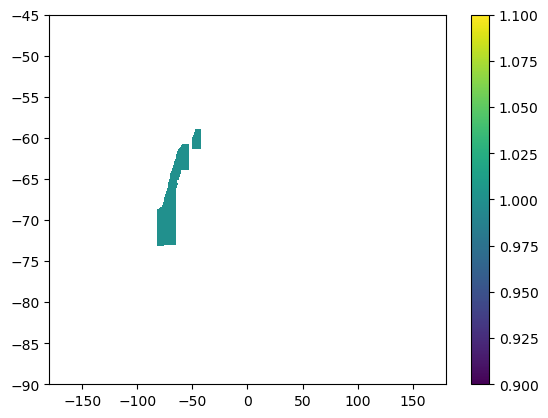

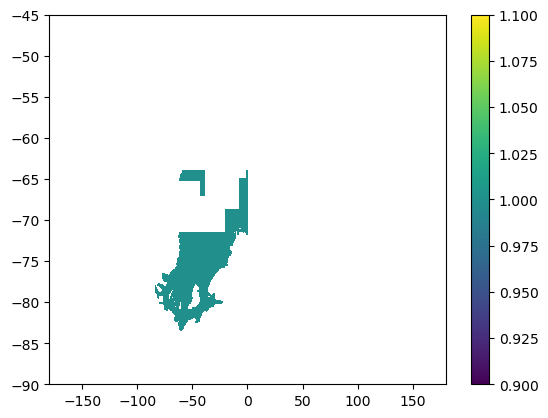

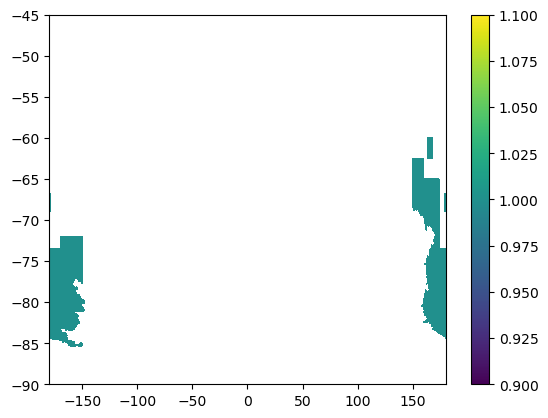

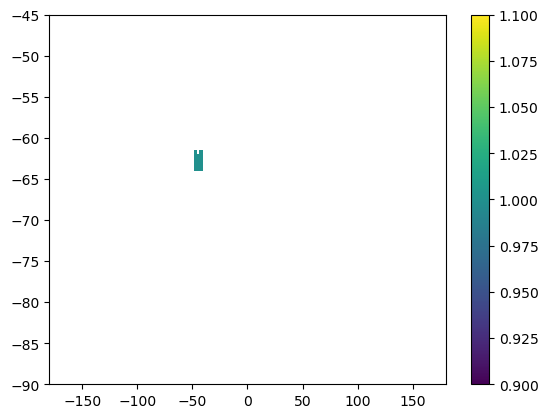

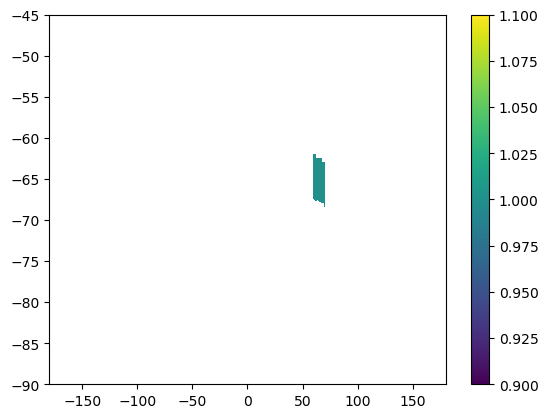

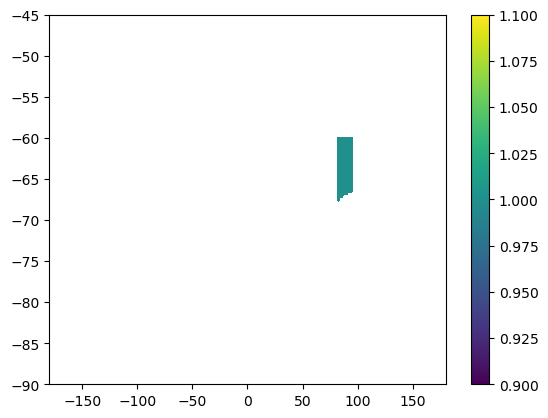

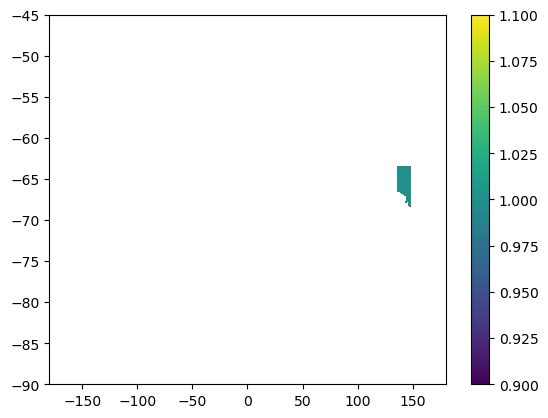

In [17]:

test_plot = True
if test_plot:
    plt.pcolor(lon2,lat2,mask_WAP.transpose())
    plt.colorbar()
    plt.show()

    plt.pcolor(lon2,lat2,mask_Weddell.transpose())
    plt.colorbar()
    plt.show()

test_plot = True
if test_plot:  
    plt.pcolor(lon2,lat2,mask_Ross.transpose())
    plt.colorbar()
    plt.show()

    plt.pcolor(lon2,lat2,mask_Orkney.transpose())
    plt.colorbar()
    plt.show()

    plt.pcolor(lon2,lat2,mask_EastAA_1.transpose())
    plt.colorbar()
    plt.show()

    plt.pcolor(lon2,lat2,mask_EastAA_2.transpose())
    plt.colorbar()
    plt.show()

    plt.pcolor(lon2,lat2,mask_EastAA_3.transpose())
    plt.colorbar()
    plt.show()

    

In [19]:
#---------
# SAVE SUBAREA AVERAGES AS NETCDF FILE
#---------

import os

save_netcdf = True
if save_netcdf: 
    # save to netcdf file
    
    saving_directory  = '/global/cscratch1/sd/cnissen/shape_files/masks_MPAs/' 
    
    mpa_list = ['RossSea','Orkney','WeddellSea','AntarcticPeninsula',\
                'East_Antarctica_1','East_Antarctica_2','East_Antarctica_3']
    
    if res==0.5:
        res_string = '0.5deg'
    elif res==1.0:
        res_string = '1deg'
    elif res==0.1:
        res_string = '0.1deg'
    elif res==0.025:
        res_string = '0.025deg'
    elif res==0.125:
        res_string = '0.125deg_toothfish_project'
        
    for rr in range(0,len(mpa_list)):
        print (mpa_list[rr]+'...')
        netcdf_name       = 'MPA_mask_'+mpa_list[rr]+'_regular_mesh_'+res_string+'.nc' 
        if mpa_list[rr] in ['RossSea']:
            data1 = mask_Ross
        elif mpa_list[rr] in ['Orkney']:
            data1 = mask_Orkney
        elif mpa_list[rr] in ['WeddellSea']:
            data1 = mask_Weddell
        elif mpa_list[rr] in ['AntarcticPeninsula']:
            data1 = mask_WAP
        elif mpa_list[rr] in ['East_Antarctica_1']:
            data1 = mask_EastAA_1
        elif mpa_list[rr] in ['East_Antarctica_2']:
            data1 = mask_EastAA_2
        elif mpa_list[rr] in ['East_Antarctica_3']:
            data1 = mask_EastAA_3
            
        fv=-999
        data1[np.isnan(data1)]=fv
        
        if save_netcdf: 
            # add a statement to only do the below if file does not yet exist.
            if not os.path.exists(saving_directory+netcdf_name):
                print ('Create file '+saving_directory+netcdf_name)
                w_nc_fid = Dataset(saving_directory+netcdf_name, 'w', format='NETCDF4_CLASSIC')

                w_nc_fid.resolution = res_string
                if mpa_list[rr] in ['RossSea','Orkney']:
                    file = file1
                elif mpa_list[rr] in ['AntarcticPeninsula','East_Antarctica_1',\
                                      'East_Antarctica_2','East_Antarctica_3']:
                    file = file2
                w_nc_fid.source_file = file
                w_nc_fid.script = '/global/homes/c/cnissen/scripts/save_mpa_on_regular_grid.ipynb'

                # create dimension & variable
                w_nc_fid.createDimension('lat', len(lat)) 
                w_nc_fid.createDimension('lon', len(lon)) 
                w_nc_fid.createVariable('lon', 'f4',('lon'))
                w_nc_fid.createVariable('lat', 'f4',('lat'))
                w_nc_fid.variables['lon'][:] = lon
                w_nc_fid.variables['lat'][:] = lat
                w_nc_var1 = w_nc_fid.createVariable('mask_mpa', 'f4',('lat','lon'),fill_value=fv)
                w_nc_var1.description = 'Mask for MPA in '+mpa_list[rr]+' (1 if in MPA)'
                w_nc_fid.close()

        if save_netcdf: 
            w_nc_fid = Dataset(saving_directory+netcdf_name, 'r+', format='NETCDF4_CLASSIC')      # Create and open new netcdf file to write to
            w_nc_fid.variables['mask_mpa'][:,:] = data1
            w_nc_fid.close()  
        del data1
        
        

RossSea...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_RossSea_regular_mesh_0.125deg_toothfish_project.nc
Orkney...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_Orkney_regular_mesh_0.125deg_toothfish_project.nc
WeddellSea...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_WeddellSea_regular_mesh_0.125deg_toothfish_project.nc
AntarcticPeninsula...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_AntarcticPeninsula_regular_mesh_0.125deg_toothfish_project.nc
East_Antarctica_1...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_East_Antarctica_1_regular_mesh_0.125deg_toothfish_project.nc
East_Antarctica_2...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_East_Antarctica_2_regular_mesh_0.125deg_toothfish_project.nc
East_Antarctica_3...
Create file /global/cscratch1/sd/cnissen/shape_files/masks_MPAs/MPA_mask_East_Antarctica_3_regular_mesh

In [ ]:
print(saving_directory+netcdf_name)
print(data1.shape)
